In [6]:
import spacy
import numpy
import os
import pathlib
from keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout
from keras.layers import TimeDistributed
from keras.models import Sequential, model_from_json
from keras.optimizers import Adam
from spacy.compat import pickle
import matplotlib.pyplot as plt


pt_br_model = 'pt_wikipedia_md'


class SentimentAnalyser(object):
    @classmethod
    def load(cls, path, nlp, max_length=100):
        """
        Loads the language model file.
        """
        with (path / 'config.json').open() as file_:
            model = model_from_json(file_.read())
        with (path / 'model').open('rb') as file_:
            lstm_weights = pickle.load(file_)
        embeddings = get_embeddings(nlp.vocab)
        model.set_weights([embeddings] + lstm_weights)
        return cls(model, max_length=max_length)

    def __init__(self, model, max_length=100):
        self._model = model
        self.max_length = max_length

    def __call__(self, doc):
        X = get_features([doc], self.max_length)
        y = self._model.predict(X)
        self.set_sentiment(doc, y)

    def pipe(self, docs, batch_size=1000, n_threads=2):
        for doc in docs:
            Xs = get_features([doc], self.max_length)
            ys = self._model.predict(Xs)
            for doc, label in zip([doc], ys):
                doc.sentiment += label
            yield doc

    def set_sentiment(self, doc, y):
        doc.sentiment = float(y[0])


def get_labelled_sentences(docs, doc_labels):
    labels = []
    sentences = []
    for doc, y in zip(docs, doc_labels):
        sentences.append(doc)
        labels.append(y)
    return sentences, numpy.asarray(labels, dtype='int32')


def get_features(docs: list, max_length):
    Xs = numpy.zeros((len(docs), max_length), dtype='int32')
    for i, doc in enumerate(docs):
        j = 0
        for token in doc:
            vector_id = token.vocab.vectors.find(key=token.orth)
            if vector_id >= 0:
                Xs[i, j] = vector_id
            else:
                Xs[i, j] = 0
            j += 1
            if j >= max_length:
                break
    return Xs


def compile_lstm(embeddings, shape, settings):
    model = Sequential()
    model.add(
        Embedding(
            embeddings.shape[0],
            embeddings.shape[1],
            input_length=shape['max_length'],
            trainable=False,
            weights=[embeddings]
        )
    )
    model.add(TimeDistributed(Dense(shape['nr_hidden'], use_bias=False)))
    model.add(Dropout(settings['dropout']))
    model.add(Bidirectional(LSTM(shape['nr_hidden'], recurrent_dropout=settings['dropout'], dropout=settings['dropout'])))
    model.add(Dropout(settings['dropout']))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(shape['nr_class'], activation='sigmoid'))
    model.compile(optimizer=Adam(lr=settings['lr']), loss='mse', metrics=['acc'])
    return model


def get_embeddings(vocab):
    return vocab.vectors.data


def train(train_texts, train_labels, dev_texts, dev_labels,
          lstm_shape, lstm_settings, lstm_optimizer, batch_size=100,
          nb_epoch=5, by_sentence=True):
    print("Loading spaCy")
    nlp = spacy.load(pt_br_model)
    embeddings = get_embeddings(nlp.vocab)
    model = compile_lstm(embeddings, lstm_shape, lstm_settings)

    print("Parsing texts...")
    train_docs = list(nlp.pipe(train_texts))
    dev_docs = list(nlp.pipe(dev_texts))
    print("Starting get_labelled_sentences()")
    if by_sentence:
        train_docs, train_labels = get_labelled_sentences(train_docs, train_labels)
        dev_docs, dev_labels = get_labelled_sentences(dev_docs, dev_labels)

    train_X = get_features(train_docs, lstm_shape['max_length'])
    dev_X = get_features(dev_docs, lstm_shape['max_length'])
    history = model.fit(train_X, train_labels, validation_data=(dev_X, dev_labels), epochs=nb_epoch, batch_size=batch_size, verbose=0)
    print("Model ready")

    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('accuracy')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    return model


def evaluate(model_dir, texts, labels, max_length=100):
    nlp = spacy.load(pt_br_model)
    nlp.add_pipe(nlp.create_pipe('sentencizer'), first=True)
    nlp.add_pipe(SentimentAnalyser.load(model_dir, nlp, max_length=max_length))
    correct = 0
    i = 0
    for doc in nlp.pipe(texts, batch_size=1000, n_threads=4):
        if doc.sentiment >= 0.5 and bool(labels[i]) is True:
            print(texts[i] + " correctly classified as True " + str(doc.sentiment))
        elif doc.sentiment >= 0.5 and bool(labels[i]) is False:
            print(texts[i] + " wrongly classified as True " + str(doc.sentiment))
        elif doc.sentiment < 0.5 and bool(labels[i]) is True:
            print(texts[i] + " wrongly classified as False " + str(doc.sentiment))
        elif doc.sentiment < 0.5 and bool(labels[i]) is False:
            print(texts[i] + " correctly classified as False " + str(doc.sentiment))
        correct += bool(doc.sentiment >= 0.5) == bool(labels[i])
        i += 1
    return float(correct) / i


train_samples = [
    ('bom', 1),
    ('perfeito', 1),
    ('rápido', 1),
    ('satisfeito', 1),
    ('excelente', 1),
    ('bom qualidade', 1),
    ('valer pena', 1),
    ('melhorar ultimamente', 1),
    ('gostar', 1),
    ('barato', 1),
    ('servir bem', 1),
    ('feliz', 1),
    ('ruim', 0),
    ('péssimo', 0),
    ('quebrado', 0),
    ('quebrar', 0),
    ('não gostar', 0),
    ('precisar melhorar', 0),
    ('demorar', 0),
    ('droga', 0),
    ('mal qualidade', 0),
    ('caro', 0),
    ('retornar', 0),
    ('não servir', 0),
    ('desapontado', 0),
    ('triste', 0)
]

validation_samples = [
    ('bom proposta', 1),
    ('servir perfeitamente', 1),
    ('acabamento perfeito', 1),
    ('qualidade impressionante', 1),
    ('marca confiança', 1),
    ('não gostar', 0),
    ('dever melhorar concorrência', 0),
    ('insatisfeito produto', 0),
    ('custar caro', 0),
    ('defeituoso', 0)
]

test_samples = [
    ('produto bom', 1),
    ('empresa bom', 1),
    ('valer pena', 1),
    ('orgulho empresa', 1),
    ('poder melhorar', 0),
    ('não gostar produto', 0),
    ('quebrar primeiro dia', 0),
    ('atendimento péssimo', 0),
    ('decepcionado', 0)
]


def execute(model_dir=None, train_dir=None, dev_dir=None,
            is_runtime=False,
            nr_hidden=64, max_length=100, # Shape
            dropout=0.5, learn_rate=0.001, # General NN config
            nb_epoch=5, batch_size=256, nr_examples=-1):  # Training params
    train_texts = [item[0] for item in train_samples]
    train_labels = [item[1] for item in train_samples]
    val_texts = [item[0] for item in validation_samples]
    val_labels = [item[1] for item in validation_samples]
    
    
    if model_dir is not None:
        if not os.path.exists(model_dir):
          os.makedirs(model_dir)
        model_dir = pathlib.Path(model_dir)
    if is_runtime:
        test_texts = [item[0] for item in test_samples];
        test_labels = [item[1] for item in test_samples];
        acc = evaluate(model_dir, test_texts, test_labels, max_length=max_length)
        print(acc)
    else:
        print("Training neural network...")
        train_labels = numpy.asarray(train_labels, dtype='int')
        val_labels = numpy.asarray(val_labels, dtype='int')
        lstm = train(train_texts, train_labels, val_texts, val_labels,
                     {'nr_hidden': nr_hidden, 'max_length': max_length, 'nr_class': 1},
                     {'dropout': dropout, 'lr': learn_rate},
                     {}, nb_epoch=nb_epoch, batch_size=batch_size)
        weights = lstm.get_weights()
        if model_dir is not None:
            with (model_dir / 'model').open('wb') as file_:
                pickle.dump(weights[1:], file_)
            with (model_dir / 'config.json').open('w') as file_:
                file_.write(lstm.to_json())


def train_network():
    execute(model_dir='binary_classification', is_runtime=False, nb_epoch=150)


def evaluate_network():
    execute(model_dir='binary_classification', is_runtime=True)

Training neural network...
Loading spaCy
Parsing texts...
Starting get_labelled_sentences()
Model ready
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


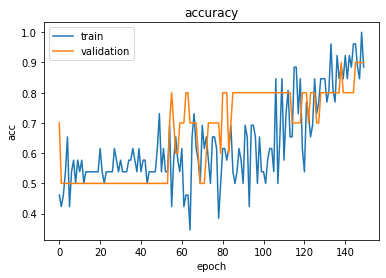

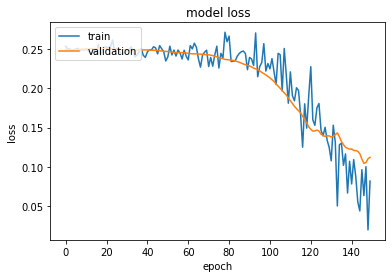

In [7]:
train_network()

In [8]:
evaluate_network()

produto bom correctly classified as True 0.9410333037376404
empresa bom correctly classified as True 0.9208372235298157
valer pena correctly classified as True 0.8807093501091003
orgulho empresa correctly classified as True 0.5789065957069397
poder melhorar wrongly classified as True 0.8022152185440063
não gostar produto correctly classified as False 0.036640286445617676
quebrar primeiro dia correctly classified as False 0.0450098030269146
atendimento péssimo correctly classified as False 0.24335184693336487
decepcionado correctly classified as False 0.11310762166976929
0.8888888888888888
